<h1>The Roots package</h1>

<p>The <code>Roots</code> package contains simple routines for finding roots of continuous scalar functions of a single real variable.  The basic interface is through the function <code>fzero</code>, which through multiple dispatch can handle many different cases.</p>

<p>We will use these pacakges</p>

In [ ]:
using Plots
using Roots

<h2>Bracketing</h2>

<p>For a function $f: R \rightarrow R$ a bracket is a pair $a<b$ for which $f(a)\cdot f(b) < 0$. That is they have different signs. If $f$ is continuous this forces there to be a zero on the interval $[a,b]$, otherwise, if $f$ is only piecewise continuous, there must be a point $c$ in $[a,b]$ with the left limit and right limit at $c$ having different signs. These values can be found, up to floating point roundoff.</p>

<p>That is, a value $a < c < b$ can be found with either <code>f&#40;c&#41; &#61;&#61; 0.0</code> or <code>f&#40;prevfloat&#40;c&#41;&#41; * f&#40;nextfloat&#40;c&#41;&#41; &lt;&#61; 0</code>.</p>

<p>To illustrate, consider the function $f(x) = \cos(x) - x$. From the graph we see readily that $[0,1]$ is a bracket:</p>

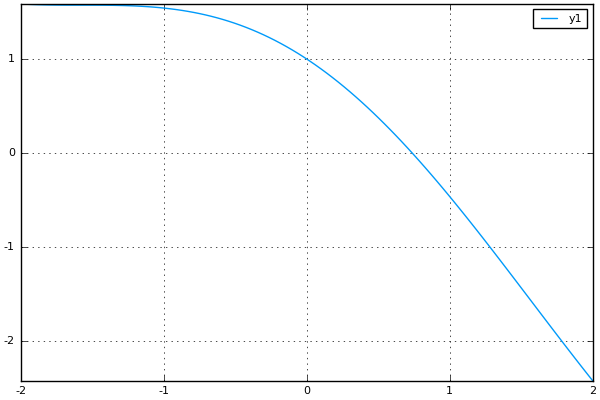

In [ ]:
f(x) = cos(x) - x
plot(f, -2,2)

<p>The basic function call specifies a bracket with two arguments"</p>

In [ ]:
x = fzero(f, 0, 1)
x, f(x)

(0.7390851332151607,0.0)

<p>For that function <code>f&#40;x&#41; &#61;&#61; 0.0</code>. Next consider $f(x) = \sin(x)$. A known root is $\pi$. Basic trignometry tells us that $[\pi/2, 3\pi2]$ will be a bracket:</p>

In [ ]:
f(x) = sin(x)
x = fzero(f, pi/2, 3pi/2)
x, f(x)

(3.141592653589793,1.2246467991473532e-16)

<p>This value of <code>x</code> does not produce <code>f&#40;x&#41; &#61;&#61; 0.0</code>, however, it is as close as can be:</p>

In [ ]:
f(prevfloat(x)) * f(x) < 0.0 || f(x) * f(nextfloat(x)) < 0.0

true

<p>That is at <code>x</code> the function is changing sign.</p>

<p>The basic algorithm used for bracketing when the values are simple floating point values is the bisection method. Though there are algorithms that mathematically should converge faster (and one is used for the case where <code>BigFloat</code> numbers are used) by exploiting floating point computations this algorithm uses fewer function calls and runs faster.</p>

<h2>Using an initial guess</h2>

<p>If a bracket is not known, but a good initial guess is, the <code>fzero</code> function provides an interface to some different algorithms. The basic algorithm is modeled after an algorithm used for <a href="http://www.hpl.hp.com/hpjournal/pdfs/IssuePDFs/1979-12.pdf">HP-34 calculators</a>. This algorithm is much more robust to the quality of the initial guess and does not rely on tolerances for a stopping rule. In many cases it satisfies the criteria for a bracketing solution.</p>

<p>For example, we have:</p>

In [ ]:
f(x) = cos(x) - x
x = fzero(f , 1)
x, f(x)

(0.7390851332151607,0.0)

<p>And </p>

In [ ]:
f(x) = x^3 - 2x - 5
x = fzero(f, 2)
x, f(x), f(prevfloat(x)) * f(nextfloat(x))

(2.0945514815423265,-8.881784197001252e-16,-2.524354896707238e-29)

<p>For even more precision, <code>BigFloat</code> numbers can be used</p>

In [ ]:
x = fzero(sin, big(3))
x, sin(x), x - pi

(3.141592653589793238462643383279503027458928160728751989361348208457812241803072,-1.432617587613536461683864036161499958355168629448483623003407589372107164223708e-34,1.432617587613536461683864036161499958355168739140227720938615263585174704284396e-34)

<h3>Higher order methods</h3>

<p>The default call to <code>fzero</code> uses a second order method at best and then bracketing, which involves potentially many more function calls. For some functions, a higher-order method might be better suited. There are algorithms of order 1 (secant method), 2 (<a href="http://en.wikipedia.org/wiki/Steffensen&#39;s_method">Steffensen</a>), 5, 8, and 16. The order 2 method is generally more efficient, but is more sensitive to the initial guess than, say, the order 8 method. These algorithms are accessed by specifying a value for the <code>order</code> argument:</p>

In [ ]:
f(x) = 2x - exp(-x)
x = fzero(f, 1, order=2)
x, f(x)

(0.3517337112491958,-1.1102230246251565e-16)

In [ ]:
f(x) = (x + 3) * (x - 1)^2
x = fzero(f, -2, order=5)
x, f(x)

(-3.0,0.0)

In [ ]:
x = fzero(f, 2, order=8)
x, f(x)

(1.0000000199240198,1.5878662626696047e-15)

<p>The latter shows that zeros need not be simple zeros (i.e. $f'(x) = 0$, if defined) to be found. For the higher-order methods, there is a tolerance that can be specified so that a value is returned as a zero if <code>abs&#40;f&#40;x&#41;&#41; &lt; tol</code>. The default method for <code>fzero</code> uses a very strict tolerance for this, otherwise defaulting to an error that at times might be very close to the actual zero. For this problem it finds the exact value:</p>

In [ ]:
x = fzero(f, 2)
x, f(x)

(1.0000000320628983,4.11211783186984e-15)

<p>But not for a similar problem:</p>

In [ ]:
fzero(x -> x^6, 1)

Roots.Dithering(0.004370030635126191)


<p>(Though the answer is basically on track, the algorithm takes too long to improve itself to the very stringent range set. For problems where a bracket is found, this dithering won't happen.)</p>

<p>The higher-order methods are basically various derivative-free versions of Newtons method which has update step $x - f(x)/f'(x)$. For example, Steffensen's method is essentially replacing $f'(x)$ with $(f(x + f(x)) - f(x))/f(x)$. This is just a forward-difference approximation to the derivative with "$h$" being $f(x)$, which presumably is close to $0$ already. The methods with higher order combine this with different secant line approaches that minimize the number of function calls. The default method uses a combination of Steffensen's method with modifications, a quadratic fit, and, if possible, a bracketing approach. It may need many more function calls than the higher-order methods. These higher-order methods can be susceptible to some of the usual issues found with Newton's method: poor initial guess, small first derivative, or large second derivative near the zero.</p>

<p>For a classic example where basically the large second derivative is the issue, we have $f(x) = x^{1/3}$:</p>

In [ ]:
f(x) = cbrt(x)
x = fzero(f, 1, order=8)	# all of 2, 5, 8, and 16 fail

Roots.ConvergenceFailed("Too many steps taken")


<p>However, the default finds the root here</p>

In [ ]:
x = fzero(f, 1)
x,  f(x)

(0.0,0.0)

<p>Finally, we show another example illustrating that the default <code>fzero</code> call is more forgiving to an initial guess. The devilish function defined below comes from a <a href="http://people.sc.fsu.edu/~jburkardt/cpp_src/test_zero/test_zero.html">test suite</a> of difficult functions. The default method finds the zero:</p>

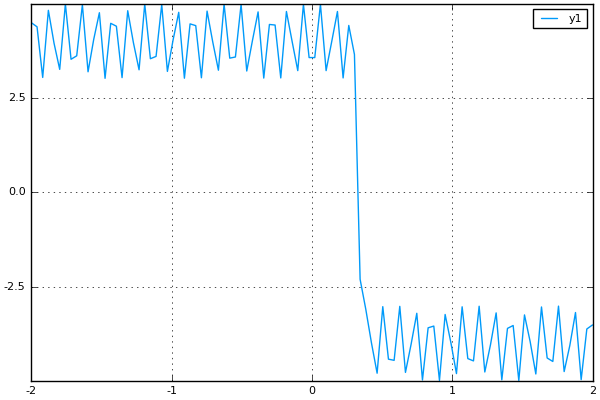

In [ ]:
f(x) = cos(100*x)-4*erf(30*x-10)
plot(f, -2, 2)

In [ ]:
fzero(f, 1)

0.33186603357456257

<p>Whereas, with <code>order&#61;n</code> methods fail. For example,</p>

In [ ]:
fzero(f, 1, order=8)

Roots.ConvergenceFailed("Too many function calls taken")


<p>Basically the high order oscillation can send the proxy tangent line off in nearly random directions.</p>

<h2>Polynomials</h2>

<p>The <code>Polynomials</code> package provides a type for working with polynomial functions that allows many typical polynomial operations to be defined. In this context, the <code>roots</code> function is used to find the roots of a polynomial.</p>

<p>For example, </p>

In [ ]:
using Polynomials
x = poly([0.0])			# (x - 0.0)
roots((x-1)*(x-2)*(x-3))

3-element Array{Float64,1}:
 1.0
 2.0
 3.0

<p>As a convenience, this package adds a function interface to <code>roots</code>:</p>

In [ ]:
f(x) = (x-1)*(x-2)*(x^2 + x + 1)
roots(f)

4-element Array{Complex{Float64},1}:
 -0.5+0.866025im
 -0.5-0.866025im
  1.0+0.0im     
  2.0+0.0im     

<p>The <code>fzeros</code> function will find the real roots of a univariate polynomial:</p>

In [ ]:
fzeros( (x-1)*(x-2)*(x^2 + x + 1))

2-element Array{Any,1}:
 1//1
  2.0

<p>As with roots, this function be called with a function:</p>

In [ ]:
f(x) = x*(x-1)*(x^2 + 1)^4
fzeros(f)

2-element Array{Real,1}:
 0
 1

<p>The algorithm can have numeric issues when the polynomial degree gets too large, or the roots are too close together.</p>

<p>The <code>multroot</code> function will also find the roots. The algorithm does a better job when there are multiple roots, as it implements an algorithm that first identifies the multiplicity structure of the roots, and then tries to improve these values.</p>

In [ ]:
multroot((x-1)*(x-2)*(x-3))	# roots, multiplicity

Dict{Any,Any} with 3 entries:
  0.9999999999999978 => 1
  2.000000000000007  => 1
  2.9999999999999925 => 1

<p>The <code>roots</code> function degrades as there are multiplicities:</p>

In [ ]:
p = (x-1)^2*(x-2)^3*(x-3)^4
roots(p)

9-element Array{Complex{Float64},1}:
 0.999999+0.0im        
      1.0+0.0im        
  1.99954+0.0im        
  2.00023+0.000398985im
  2.00023-0.000398985im
  2.99787+0.00213481im 
  2.99787-0.00213481im 
  3.00213+0.00212188im 
  3.00213-0.00212188im 

<p>Whereas, <code>multroot</code> gets it right.</p>

In [ ]:
multroot(p)

Dict{Any,Any} with 3 entries:
  1.0000000000000007 => 2
  1.9999999999999978 => 3
  3.0000000000000013 => 4

<p>The difference gets dramatic when the multiplicities get quite large.</p>

<p>For polynomial functions over the integers or rational numbers, the <code>factor</code> function will factor over the integers:</p>

In [ ]:
factor(x -> (x-1)^2*(x-3)^4*(5x-6)^7)

Dict{Polynomials.Poly{BigInt},Int64} with 3 entries:
  Poly(-3 + x)   => 4
  Poly(-1 + x)   => 2
  Poly(-6 + 5⋅x) => 7

<h2>Classical methods</h2>

<p>The package provides some classical methods for root finding: <code>newton</code>, <code>halley</code>, and <code>secant_method</code>. We can see how each works on a problem studied by Newton himself. Newton's method uses the function and its derivative:</p>

In [ ]:
f(x) = x^3 - 2x - 5
fp(x) = 3x^2 - 2
x = newton(f, fp, 2)
x, f(x), f(prevfloat(x)) * f(nextfloat(x))

(2.0945514815423265,-8.881784197001252e-16,-2.524354896707238e-29)

<p>To see the algorithm in progress, the argument <code>verbose&#61;true</code> may be specified. </p>

<p>The secant method needs two starting points, here we start with 2 and 3:</p>

In [ ]:
x = secant_method(f, 2,3)
x, f(x), f(prevfloat(x)) * f(nextfloat(x))

(2.0945514815423265,-8.881784197001252e-16,-2.524354896707238e-29)

<p>Halley's method has cubic convergence, as compared to Newton's quadratic convergence. It uses the second derivative as well:</p>

In [ ]:
fpp(x) = 6x
x = halley(f, fp, fpp, 2)
x, f(x), f(prevfloat(x)) * f(nextfloat(x))

(2.0945514815423265,-8.881784197001252e-16,-2.524354896707238e-29)

<p>For many function, the derivatives can be computed automatically. The <code>ForwardDiff</code> package provides a means. This package wraps the process into an operator, <code>D</code> which returns the derivative of a function <code>f</code> (for simple-enough functions):</p>

In [ ]:
newton(f, D(f), 2)

2.0945514815423265

<p>The usual notation can be added through:</p>

In [ ]:
Base.ctranspose(f::Function) = x -> D(f)(x)

ctranspose (generic function with 38 methods)

<p>Then <code>f&#39;</code> can replace <code>D&#40;f&#41;</code>.</p>

<p>For Halley's method</p>

In [ ]:
halley(f, f', f'', 2)

2.0945514815423265

<p>(If not specified, the derivatives will default to these calls.)</p>

<h2>Finding critical points</h2>

<p>The <code>D</code> function makes it straightforward to find critical points (where the derivative is $0$ or undefined). For example, the critical point of the function $f(x) = 1/x^2 + x^3, x > 0$ can be found with:</p>

In [ ]:
f(x) = 1/x^2 + x^3
fzero(f', 1)

0.9221079114817278

<p>For more complicated expressions, <code>D</code> will not work. In this example, we have a function $f(x, \theta)$ that models the flight of an arrow on a windy day:</p>

In [ ]:
function flight(x, theta)
 	 k = 1/2
	 a = 200*cosd(theta)
	 b = 32/k
	 tand(theta)*x + (b/a)*x - b*log(a/(a-x))
end

flight (generic function with 1 method)

<p>The total distance flown is when <code>flight&#40;x&#41; &#61;&#61; 0.0</code> for some <code>x &gt; 0</code>: This can be solved for different <code>theta</code> with <code>fzero</code>. In the following, we note that <code>log&#40;a/&#40;a-x&#41;&#41;</code> will have an asymptote at <code>a</code>, so we start our search at <code>a-1</code>:</p>

In [ ]:
function howfar(theta)
	 a = 200*cosd(theta)
	 fzero(x -> flight(x, theta), a-1)
end

howfar (generic function with 1 method)

<p>To see the trajectory if shot at 30 degrees, we have:</p>

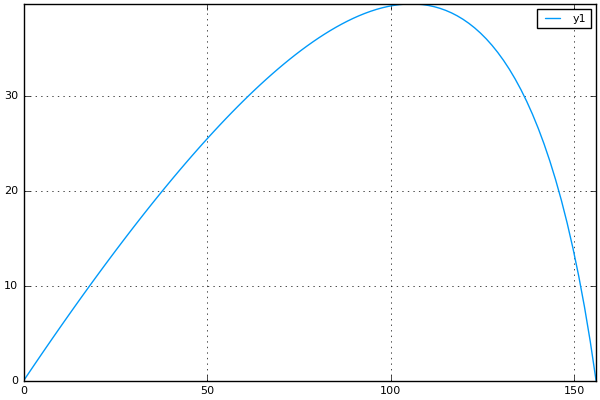

In [ ]:
theta = 30
plot(x -> flight(x,  theta), 0, howfar(theta))

<p>To maximize the range we solve for the lone critical point of <code>howfar</code> within the range. The derivative can not be taken automatically with <code>D</code>. So,  here we use a central-difference approximation and start the search at 45 degrees, the angle which maximizes the trajectory on a non-windy day:</p>

In [ ]:
h = 1e-5
howfarp(theta) = (howfar(theta+h) - howfar(theta-h)) / (2h)
fzero(howfarp, 45)

26.262308924144275